In [1]:
import pandas as pd

# COVID-19

In [2]:
# Read

In [3]:
data = pd.read_csv('latest.csv')

In [4]:
data.Region_ID.unique()

array([18, 30,  1, 15,  3, 11,  2,  9,  5, 25,  7, 31, 17, 19, 22, 21, 10,
       14, 23,  4, 24, 12, 20,  8,  6, 13, 26, 28, 32, 27, 16, 29])

In [5]:
data.isnull().head(), data.isnull().tail()

(   Date_Confirmed  Date_Symptoms  Date_Death  Region  Region_ID  Region_Key  \
 0           False          False       False   False      False       False   
 1           False          False       False   False      False       False   
 2           False          False       False   False      False       False   
 3           False          False       False   False      False       False   
 4           False          False       False   False      False       False   
 
    Origin  Status  
 0   False   False  
 1   False   False  
 2   False   False  
 3   False   False  
 4   False   False  ,
        Date_Confirmed  Date_Symptoms  Date_Death  Region  Region_ID  \
 29875           False          False       False   False      False   
 29876           False          False       False   False      False   
 29877           False          False       False   False      False   
 29878           False          False       False   False      False   
 29879           False         

In [6]:
data.isnull().values.any()

False

In [7]:
data.isnull().values.sum()

0

In [8]:
#To use symptoms as indicator, uncomment the next two lines:
#data = data.drop(['Date_Confirmed'], axis=1)
#data = data.rename(columns={'Date_Symptoms':'Date_Confirmed'}) # Rename index

In [9]:
# Totals and delta

In [10]:
    # Region delta (ie, new cases)
cum_df = (data.groupby(['Region','Date_Confirmed'])['Date_Confirmed'].count()).to_frame()

In [11]:
    # Rename because duplicate index
cum_df['Region_Delta'] = cum_df['Date_Confirmed']

In [12]:
    # Region cumulative by date
cum_df['Region_Cumulative'] = cum_df.groupby(['Region'])['Region_Delta'].cumsum()

In [13]:
    # Clean up
cum_df = cum_df.drop(['Date_Confirmed'], axis=1)

In [14]:
# To view full table:
# from IPython.core.display import HTML
# display(HTML(cum_df.to_html()))

# Tables

In [15]:
# Read

In [16]:
pivot_tbl_cum = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.reset_index()
pivot_tbl_daily = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Delta').T.reset_index()

In [17]:
# Save

In [18]:
pivot_tbl_cum.to_csv('time_series/total-mexico-covid19.csv', index=False)
pivot_tbl_daily.fillna(0).to_csv('time_series/daily-mexico-covid19.csv', index=False)

In [19]:
# Set datetime

In [20]:
pivot_tbl_cum['Date_Confirmed'] = pd.to_datetime(pivot_tbl_cum.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_cum['Date_Confirmed'] = pivot_tbl_cum['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [21]:
# Set datetime

In [22]:
pivot_tbl_daily['Date_Confirmed'] = pd.to_datetime(pivot_tbl_daily.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_daily['Date_Confirmed'] = pivot_tbl_daily['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [23]:
# Set index

In [24]:
pivot_tbl_cum = pivot_tbl_cum.set_index(pd.DatetimeIndex(pivot_tbl_cum['Date_Confirmed']))
pivot_tbl_daily = pivot_tbl_daily.set_index(pd.DatetimeIndex(pivot_tbl_daily['Date_Confirmed']))

# Plots

In [25]:
from numpy import *
import math
import matplotlib.pyplot as plt

### Confirmed cases

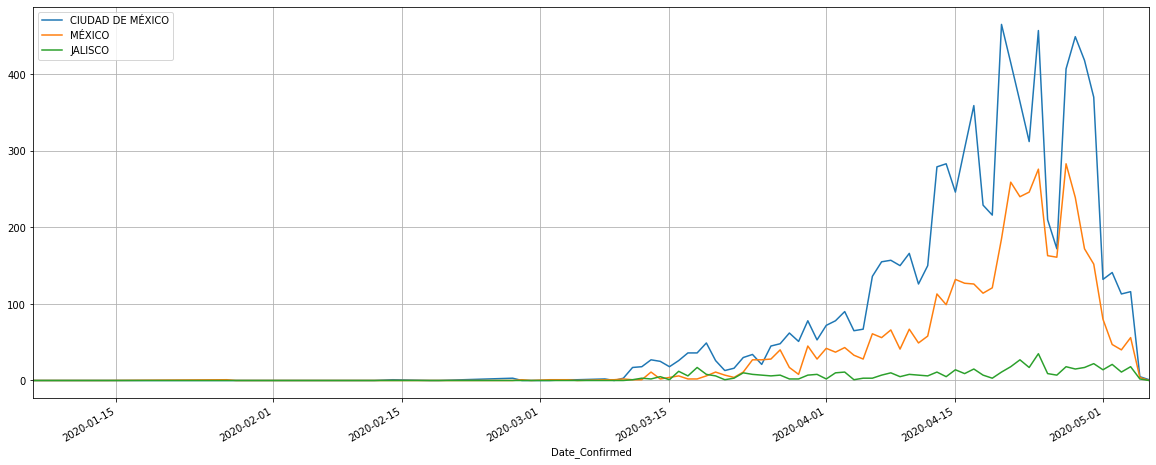

In [26]:
plt.figure(figsize=(20,8))

for state in ['CIUDAD DE MÉXICO', 'MÉXICO', 'JALISCO',]:
    pivot_tbl_daily[state].fillna(0).plot()

plt.legend()
plt.grid(True)
plt.show()

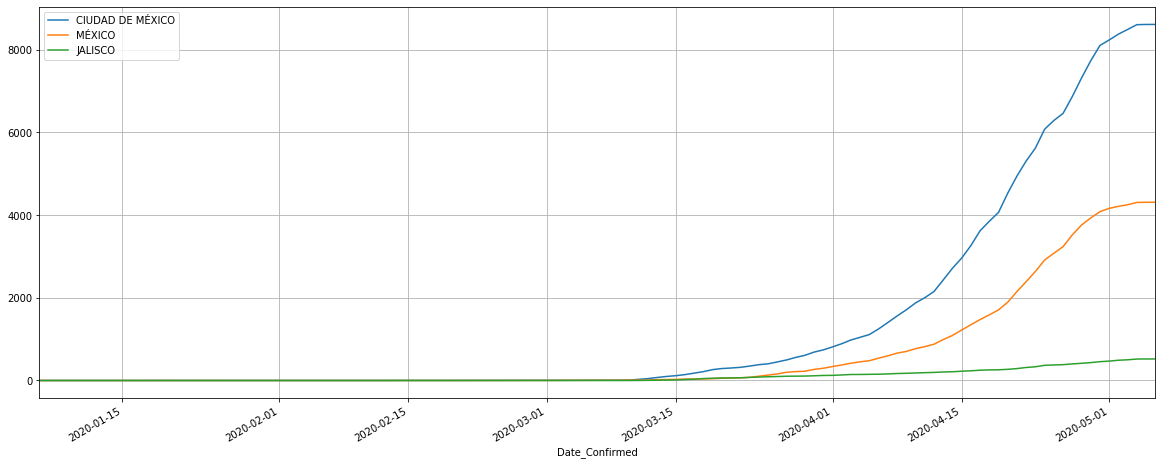

In [27]:
plt.figure(figsize=(20,8))

for state in ['CIUDAD DE MÉXICO', 'MÉXICO', 'JALISCO',]:
    pivot_tbl_daily[state].fillna(0).cumsum().plot()

plt.legend()
plt.grid(True)
plt.show()

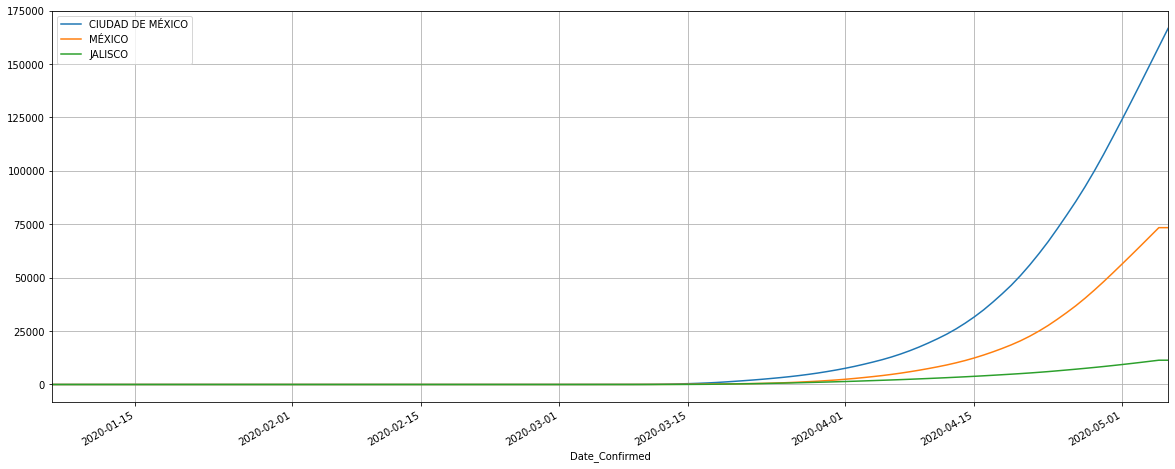

In [28]:
plt.figure(figsize=(20,8))

for state in ['CIUDAD DE MÉXICO', 'MÉXICO', 'JALISCO',]:
    pivot_tbl_cum[state].fillna(0).cumsum().plot()

plt.legend()
plt.grid(True)
plt.show()

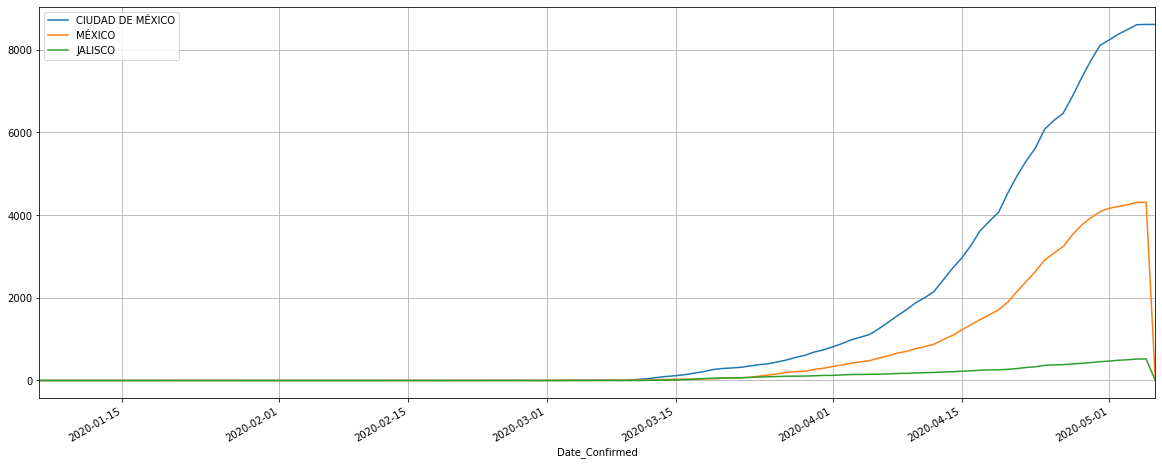

In [29]:
plt.figure(figsize=(20,8))

for state in ['CIUDAD DE MÉXICO', 'MÉXICO', 'JALISCO',]:
    pivot_tbl_cum[state].fillna(0).plot()

plt.legend()
plt.grid(True)
plt.show()

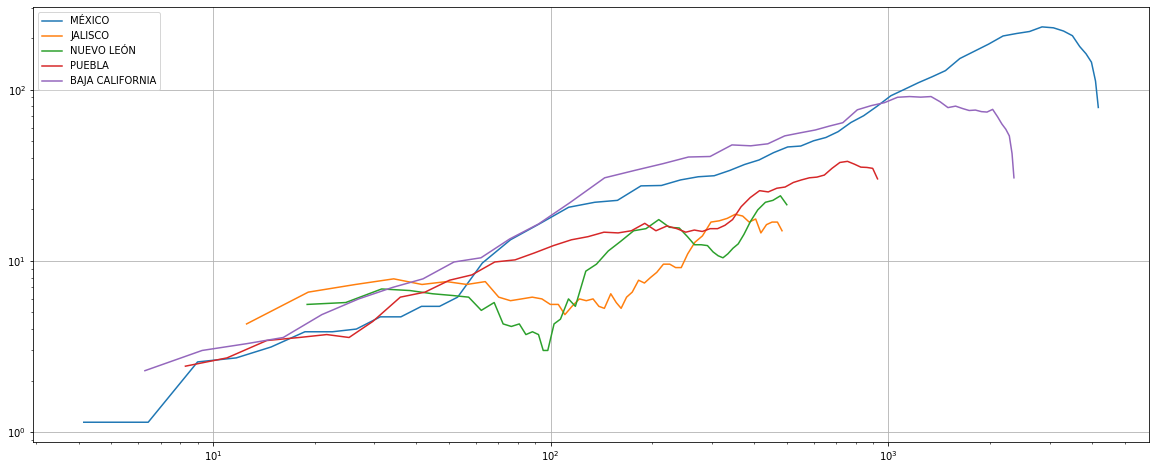

In [30]:
plt.figure(figsize=(20,8))

for state in ['MÉXICO', 'JALISCO', 'NUEVO LEÓN', 'PUEBLA', 'BAJA CALIFORNIA']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label=state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

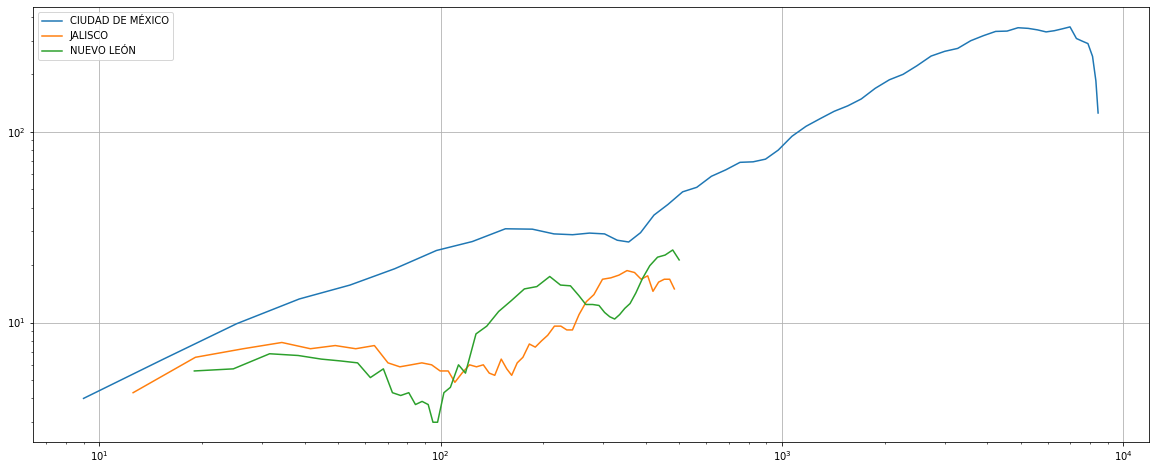

In [31]:
plt.figure(figsize=(20,8))

for state in ['CIUDAD DE MÉXICO', 'JALISCO', 'NUEVO LEÓN']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label = state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

### Lag in cases reported

In [32]:
import janitor
test = pivot_tbl_daily
abr_19 = test.filter_date('Date_Confirmed','2020-02-01','2020-04-19')

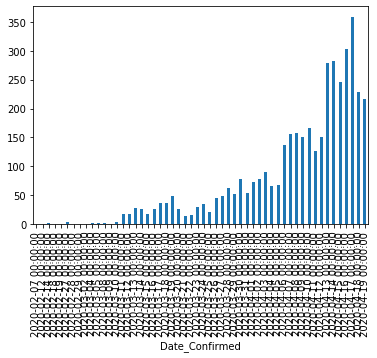

In [33]:
abr_19['CIUDAD DE MÉXICO'].plot(kind='bar', title='')